In [1]:
import xarray as xr
import xgcm
import matplotlib.pyplot as plt
import dask
import cmocean
import gsw
import cosima_cookbook as cc
import numpy as np

%matplotlib inline




# Initialise Cluster
Create aDask cluster using Gadi nodes

In [2]:
import os
import dask.config
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster
walltime = '03:00:00'
cores = 28
memory = '192GB'
  
cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory),processes=cores,
                     job_extra=['-q normalbw','-P jk72','-l ncpus='+str(cores),'-l mem='+str(memory),
                                '-l storage=gdata/ik11+gdata/jk72+gdata/v45+gdata/qv56+gdata/hh5+gdata/cj50',
                                '-l jobfs=60GB'],
                     local_directory='$TMPDIR',
                     header_skip=["select"],
                     # python=os.environ["DASK_PYTHON"]
                    )
cluster.scale(jobs=6)

In [3]:
# either way, run this
client = Client(cluster)


In [4]:
cluster

In [5]:
print(client)

<Client: 'tcp://10.6.121.5:45951' processes=0 threads=0, memory=0 B>


In [2]:
!squeue


/bin/bash: squeue: command not found


# Load datasets

In [6]:
session = cc.database.create_session()#db='/g/data/ik11/databases/cosima_master_2022-07-01.db')

# reference density value:
rho_0 = 1035.0
g = 9.81

# Restrict to Southern Ocean latitudes
lat_range = slice(-80,-35)

In [7]:
# 1/10th experiment for actual analysis

# expt = '01deg_jra55v140_iaf_cycle3'
expt = '01deg_jra55v140_iaf_cycle4'

start_time = '1958-01-01'
# start_time = '2008-01-01'

end_time = '2018-12-31'

# # 1 degree experiemnt for algorithm development

# expt = '1deg_jra55_ryf9091_gadi'
# start_time = '2660-01-01'
# end_time = '2680-01-01'

# # 0.25experiment for algorithm development
# expt = '025deg_jra55_iaf_omip2_cycle6'
# start_time = '1958-01-01'
# end_time = '2018-12-31'

In [8]:
# Restrict to Southern Ocean to save memory/time
lat_range = slice(-80,-35.5)

In [9]:
time_slice = slice(start_time, end_time)

## Cells for interogating experiments and identifying variables

# Load variables

In [10]:
%%time
sw_ocean = cc.querying.getvar(expt,'sw_ocean', session, n=-1)
sw_edges_ocean = cc.querying.getvar(expt,'sw_edges_ocean', session, n=-1)
st_ocean = cc.querying.getvar(expt,'st_ocean', session, n=-1)
st_edges_ocean= cc.querying.getvar(expt,'st_edges_ocean', session, n=-1)

dstF = xr.DataArray(st_edges_ocean.values[1:] - st_edges_ocean.values[:-1],
                   coords={'st_ocean':st_ocean},
                   dims={'st_ocean':st_ocean})

CPU times: user 22.2 s, sys: 4.43 s, total: 26.7 s
Wall time: 38.6 s


In [11]:
# u = cc.querying.getvar(expt,'u', session)

# wt = cc.querying.getvar(expt,'wt', session)

In [12]:
%%time

ty_trans = cc.querying.getvar(expt,'ty_trans', session, start_time = start_time, end_time = end_time)
ty_trans = ty_trans.sel(time=time_slice).sel(yu_ocean=lat_range)

# if need to compute manually from velocity use this code
# v = cc.querying.getvar(expt, 'v', session, start_time = start_time, end_time = end_time)
# v = v.sel(time=time_slice).sel(yu_ocean=lat_range)
# dxu = cc.querying.getvar(expt,'dxu', session, n=-1)
# ty_trans = v*dxu*dst*rho_0

days_in_month = ty_trans.time.dt.days_in_month
#print(days_in_month)

total_days = days_in_month.sum()
#print(total_days)

<xarray.DataArray 'days_in_month' (time: 732)>
array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31,
       30, 31, 31, 30, 31, 30, 31, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31,
       30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31,
       30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31,
       30, 31, 30, 31, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31,
       28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30,
       31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30,
       31, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30,
       31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30,
       31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 29,
       31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31,
       31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31,
       31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31

In [13]:
%%time

ty_trans_rho = cc.querying.getvar(expt,'ty_trans_rho', session, start_time = start_time, end_time = end_time)
ty_trans_rho = ty_trans_rho.sel(time=time_slice).sel(grid_yu_ocean=lat_range)
ty_trans_rho = ty_trans_rho.rename({'grid_yu_ocean':'yu_ocean', 'grid_xt_ocean':'xt_ocean'})

CPU times: user 25.9 s, sys: 1.83 s, total: 27.7 s
Wall time: 26.1 s


In [14]:
%%time

pot_rho_2 = cc.querying.getvar(expt,'pot_rho_2', session, start_time = start_time, end_time = end_time)
pot_rho_2 = pot_rho_2.sel(time=time_slice).sel(yt_ocean=lat_range)


CPU times: user 27.5 s, sys: 1.85 s, total: 29.3 s
Wall time: 27.6 s


In [15]:
%%time

potrho_edges = cc.querying.getvar(expt,'potrho_edges', session, n=1,frequency = '1 monthly' )

pot_rho_2_midpoints = (potrho_edges[1:] + potrho_edges[:-1])/2

potrho = cc.querying.getvar(expt,'potrho', session, n=1,frequency = '1 monthly' )




CPU times: user 4.69 s, sys: 1.51 s, total: 6.2 s
Wall time: 4.72 s


In [16]:
%%time

# may need to add file='ocean_monthly.nc' to this for some configurations
temperature = cc.querying.getvar(expt,'temp', session, start_time = start_time, end_time = end_time,frequency = '1 monthly')
temperature = temperature.sel(time=time_slice).sel(yt_ocean=lat_range)


CPU times: user 24.8 s, sys: 2.01 s, total: 26.8 s
Wall time: 25.1 s


## Define grid and metrics

In [17]:
ds = xr.Dataset({'ty_trans':ty_trans,'pot_rho_2':pot_rho_2,
                 'sw_ocean':sw_ocean, 'st_edges_ocean':st_edges_ocean}) 
grid = xgcm.Grid(ds, coords={'X':{'center':'xt_ocean'},
                             'Y':{'center':'yt_ocean','right':'yu_ocean'},
                             'Z':{'center':'st_ocean', 'outer':'st_edges_ocean', 'right':'sw_ocean'}}, periodic = ['X'])



In [18]:
grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   xt_ocean
Y Axis (not periodic, boundary=None):
  * center   yt_ocean --> right
  * right    yu_ocean --> center
Z Axis (not periodic, boundary=None):
  * center   st_ocean --> right
  * outer    st_edges_ocean --> center
  * right    sw_ocean --> center

# Analysis

## Intial Exploration

## Calculate layerwise fluxes using the monthly means
 TODO: rewrite this description using ACCESS-OM2-01 names instead of MITgcm names

Define density, regrid `VVEL`, `THETA`, and `ADVy_TH` into density space. Need to multipy `VVEL` and `THETA` by `drF` to make them extensive quantities. Also regrid an array of `drF` to get the thickness.

In [19]:
# Choose the time periods for the analysis
time_ave_period = "10Y"

In [22]:
# Select decade around a particular year:
    
analysis_year = '2015'

def calc_decade_lims(year):

    foo = ((temperature*days_in_month).resample(time=time_ave_period).sum(dim='time')/
               days_in_month.resample(time=time_ave_period).sum(dim='time')).rename('foo')

    time_lims = [foo.time.sel(time=year, method='ffill').values,
                 foo.time.sel(time=year, method='bfill').values]

    import pandas as pd


    decade_lims = [str(pd.to_datetime(time_lims[0]).year),
                  str(pd.to_datetime(time_lims[1]).year)]
        
    return decade_lims

decade_lims = calc_decade_lims(analysis_year)

In [23]:
decade_lims

['2008', '2018']

In [24]:
#move to required location for interpolation (pot_rho to ty_trans location)
pot_rho_2_yu = grid.interp(pot_rho_2, axis=['Y'], boundary='extend')


CPU times: user 44.1 s, sys: 2.14 s, total: 46.3 s
Wall time: 55.1 s


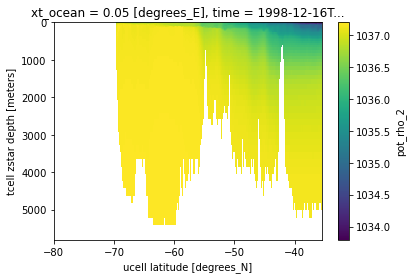

In [27]:
%%time
pot_rho_2_yu.where(pot_rho_2_yu > 0).sel(xt_ocean=0,
            method='nearest').sel(time='1998-12-15', method='nearest').plot(yincrease=False)#vmin=35.5, vmax=37.75)

## Overturning circulations

'Residual', or total, overturning
$$
\Psi = \frac{1}{T}\int_{0}^{T} \oint \sum_{i = 1}^{N} v(x,y,\sigma_{2i})h(x,y,\sigma_{2i}) dx dt
$$

Eulerian-mean overturning
$$
\overline{\Psi} = \oint \sum_{i=1}^{N} \overline{v}(x,y,\sigma_{2i})\overline{h}(x,y,\sigma_{2i}) dx
$$

Transient eddy overturning
$$
\Psi^{*} = \Psi - \overline{\Psi}
$$

Could also define the transient eddy overturning by defining $v'$, and $h'$, but numerically this doesn't work so well.

Now, we want to break the Eulerian-mean overturning into standing meander and zonal-mean components.

Zonal-mean Eulerian-mean overturning
$$
<\overline{\Psi}> = L \sum_{i=1}^{N} <\overline{v}>(y,\sigma_{2i}) <\overline{h}>(y,\sigma_{2i})
$$

Standing meander Eulerian-mean overturning
$$
\Psi_{SM} = \overline{\Psi} - <\overline{\Psi}>
$$

In [25]:
from xhistogram.xarray import histogram


In [26]:
def cumsum_from_bottom (transports, dim='potrho'):
    cumsum_from_bottom = (transports.cumsum(dim)-transports.sum(dim))
    return cumsum_from_bottom

In [28]:
%%time

# try to load a precalculated field. If not, compute it and save to disk.
try:
    psi = xr.open_dataarray('/g/data/jk72/ed7737/SO-channel_embayment/ACESS-OM2/'+
                            '{0}/data/psi_{1}_{2}.nc'.format(expt, decade_lims[0], decade_lims[1]), chunks='auto')
except:
    psi = ((ty_trans_rho*days_in_month).resample(time=time_ave_period).sum(dim='time')/
           days_in_month.resample(time=time_ave_period).sum(dim='time')).rename('psi')
    
    # psi = psi.load()
    psi.sel(time=decade_lims[1], method='nearest').to_netcdf('/g/data/jk72/ed7737/SO-channel_embayment/'+
                            'ACESS-OM2/{0}/data/psi_{1}_{2}.nc'.format(expt, decade_lims[0], decade_lims[1]))

CPU times: user 1.01 s, sys: 295 ms, total: 1.3 s
Wall time: 1.63 s


In [29]:
%%time
try:
    ty_trans_bar = xr.open_dataarray('/g/data/jk72/ed7737/SO-channel_embayment/ACESS-OM2/'+
                                     '{0}/data/ty_trans_bar_{1}_{2}.nc'.format(expt, decade_lims[0], decade_lims[1]), chunks='auto')
except:
    ty_trans_bar = ((ty_trans*days_in_month).resample(time=time_ave_period).sum(dim='time')/
                days_in_month.resample(time=time_ave_period).sum(dim='time')).rename('ty_trans_bar')
    
    # ty_trans_bar = ty_trans_bar.load()
    ty_trans_bar.sel(time=decade_lims[1], method='nearest').to_netcdf('/g/data/jk72/ed7737/SO-channel_embayment/ACESS-OM2/'+
                           '{0}/data/ty_trans_bar_{1}_{2}.nc'.format(expt, decade_lims[0], decade_lims[1]))

    

CPU times: user 115 ms, sys: 13.1 ms, total: 128 ms
Wall time: 134 ms


In [30]:
%%time

try:
    pot_rho_2_yu_bar = xr.open_dataarray('/g/data/jk72/ed7737/SO-channel_embayment/ACESS-OM2/'+
                                         '{0}/data/pot_rho_2_yu_bar_{1}_{2}.nc'.format(expt, decade_lims[0],
                                                                                       decade_lims[1]), chunks='auto')
except:
    pot_rho_2_yu_bar = ((pot_rho_2_yu*days_in_month).resample(time=time_ave_period).sum(dim='time')/
                            days_in_month.resample(time=time_ave_period).sum(dim='time'))
    pot_rho_2_yu_bar.name = 'pot_rho_2_yu_bar'

    # pot_rho_2_yu_bar = pot_rho_2_yu_bar.load()
    pot_rho_2_yu_bar.sel(time=decade_lims[1], method='nearest').to_netcdf('/g/data/jk72/ed7737/SO-channel_embayment/ACESS-OM2/'+
                               '{0}/data/pot_rho_2_yu_bar_{1}_{2}.nc'.format(expt, decade_lims[0], decade_lims[1]))


CPU times: user 18.2 ms, sys: 6.02 ms, total: 24.3 ms
Wall time: 97.8 ms


In [ ]:
%%time

try:
    psi_bar = xr.open_dataarray('/g/data/jk72/ed7737/SO-channel_embayment/ACESS-OM2/'+
                                '{0}/data/psi_bar_{1}_{2}.nc'.format(expt, decade_lims[0], decade_lims[1]), chunks='auto')
except:
    psi_bar = histogram(pot_rho_2_yu_bar, 
                          bins=[potrho_edges.values], 
                          dim = ['st_ocean'],
                          weights=ty_trans_bar).rename({'pot_rho_2_yu_bar_bin':'potrho'}).rename('psi_bar')

    # psi_bar = psi_bar.load()
    psi_bar.sel(time=decade_lims[1], method='nearest').to_netcdf('/g/data/jk72/ed7737/SO-channel_embayment/ACESS-OM2/'+
                                                                 '{0}/data/psi_bar_{1}_{2}.nc'.format(expt, decade_lims[0],
                                                                                                      decade_lims[1]))



In [ ]:


%%time

try:
    hbar = xr.open_dataarray('/g/data/jk72/ed7737/SO-channel_embayment/ACESS-OM2/'+
                             '{0}/data/hbar_{1}_{2}.nc'.format(expt, decade_lims[0], decade_lims[1]), chunks='auto')
except:
    hbar = histogram(pot_rho_2_yu_bar, 
                          bins=[potrho_edges.values], 
                          dim = ['st_ocean'],
                          weights=xr.ones_like(ty_trans_bar)*dstF).rename({'pot_rho_2_yu_bar_bin':'potrho'}).rename('hbar')

    # hbar = hbar.load()
    hbar.sel(time=decade_lims[1], method='nearest').to_netcdf('/g/data/jk72/ed7737/SO-channel_embayment/ACESS-OM2/'+
                                                              '{0}/data/hbar_{1}_{2}.nc'.format(expt, decade_lims[0],
                                                                                                decade_lims[1]))


In [33]:
%%time

XL = np.tile(pot_rho_2_yu_bar.yu_ocean, (len(potrho_edges)-1,1)).T


YL = -hbar.mean(dim='xt_ocean').cumsum(dim='potrho').compute()


CPU times: user 5.54 s, sys: 287 ms, total: 5.83 s
Wall time: 15.6 s


In [34]:
# Calculate eddy overturning by difference

psi_star = psi - psi_bar

#### Plot residual, Eulerian, and eddy overturning Circulations
Looks like the Eulerian-mean circulation doesn't quite close - there is a non-zero value at the surface.
Partial cells? Averaging issue? 

KeyError: 'no index found for coordinate time'

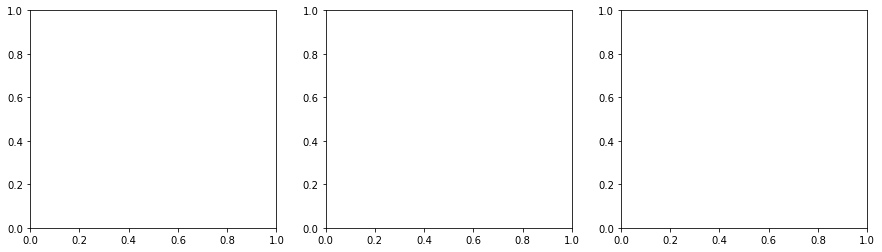

In [35]:
%%time

fig, ax = plt.subplots(1,3, figsize=(15,4))
levels=np.linspace(-25,25,50,)*1e6

cumsum_from_bottom((psi.sel(time=analysis_year,
                            method='nearest')/rho_0).sum(dim='xt_ocean')).plot.contourf(ax=ax[0],
                                            y='potrho', yincrease=False, levels=levels)# robust=True)#, levels=levels)
ax[0].set_title('$\Psi$')

cumsum_from_bottom((psi_bar.sel(time=analysis_year,
                                method='nearest')/rho_0).sum(dim='xt_ocean')).plot.contourf(ax=ax[1],
                                            y='potrho', yincrease=False, levels=levels)# robust=True)#, levels=levels)
ax[1].set_title('$\overline{\Psi}$')


cumsum_from_bottom((psi_star.sel(time=analysis_year,
                                 method='nearest')/rho_0).sum(dim='xt_ocean')).plot.contourf(ax=ax[2],
                                            y='potrho', yincrease=False, levels=levels)# robust=True)#, levels=levels)
ax[2].set_title('$\Psi^{*}$')

fig.suptitle('Decade ending {0}'.format(decade_lims[1]));

plt.savefig('/g/data/jk72/ed7737/SO-channel_embayment/ACESS-OM2/{0}/figures/psi_mean_eddy_{1}_{2}_sigma_space.png'.format(
    expt, decade_lims[0], decade_lims[1]), dpi=200, bbox_inches='tight')

KeyError: 'no index found for coordinate time'

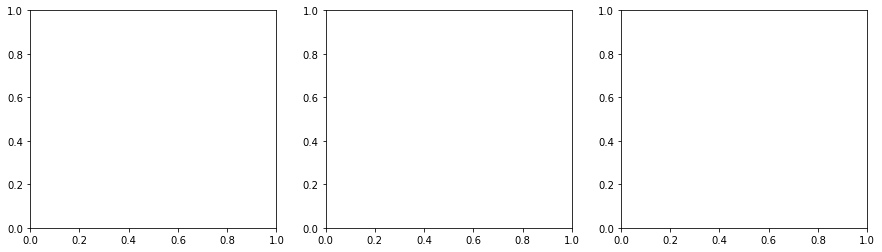

In [36]:
%%time

fig, ax = plt.subplots(1,3, figsize=(15,4))

(psi.sel(time=analysis_year, method='nearest').sum(dim='xt_ocean')/rho_0).plot(ax=ax[0], y='potrho', yincrease=False, robust=True)
ax[0].set_title('$\Psi$')
# ax[0].set_ylim(37,36)

(psi_bar.sel(time=analysis_year, method='nearest').sum(dim='xt_ocean')/rho_0).plot(ax=ax[1], y='potrho', yincrease=False, robust=True)
ax[1].set_title('$\overline{\Psi}$')


(psi_star.sel(time=analysis_year, method='nearest').sum(dim='xt_ocean')/rho_0).plot(ax=ax[2], y='potrho', yincrease=False, robust=True)
ax[2].set_title('$\Psi^{*}$')

fig.suptitle('Decade ending {0}'.format(decade_lims[1]));



KeyError: 'time is not a valid dimension or coordinate'

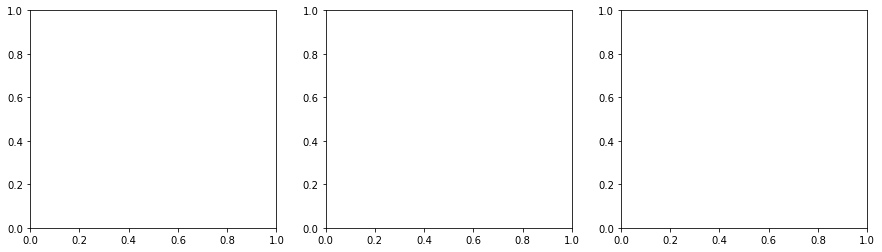

In [37]:
%%time

fig, ax = plt.subplots(1,3, figsize=(15,4))

im = ax[0].contourf(XL, YL.sel(time=analysis_year, method='nearest'),
                    cumsum_from_bottom(psi.sel(time=plot_year,
                method='nearest').sum(dim='xt_ocean')).T/rho_0, robust=True, cmap='RdBu_r', vmin=-25e6, vmax=25e6)
ax[0].set_title('$\Psi$')
plt.colorbar(im, ax=ax[0])

im2 = ax[1].contourf(XL, YL.sel(time=analysis_year, method='nearest'),
                     cumsum_from_bottom(psi_bar.sel(time=plot_year,
                    method='nearest').sum(dim='xt_ocean'))/rho_0, robust=True, cmap='RdBu_r', vmin=-25e6, vmax=25e6)
ax[1].set_title('$\overline{\Psi}$')
plt.colorbar(im2, ax=ax[1])

im3 = ax[2].contourf(XL, YL.sel(time=analysis_year, method='nearest'),
                     cumsum_from_bottom(psi_star.sel(time=plot_year,
                        method='nearest').sum(dim='xt_ocean')).T/rho_0, robust=True, cmap='RdBu_r', vmin=-25e6, vmax=25e6)
ax[2].set_title('$\Psi^{*}$')
plt.colorbar(im3, ax=ax[2])

fig.suptitle('Decade ending {0}'.format(decade_lims[1]));

# blue rotates counter-clockwise

plt.savefig('/g/data/jk72/ed7737/SO-channel_embayment/ACESS-OM2/{0}/figures/psi_mean_eddy_{1}_to_{2}_depth_space.png'.format(
    expt, decade_lims[0], decade_lims[1]), dpi=200, bbox_inches='tight')

NameError: name 'plot_year' is not defined

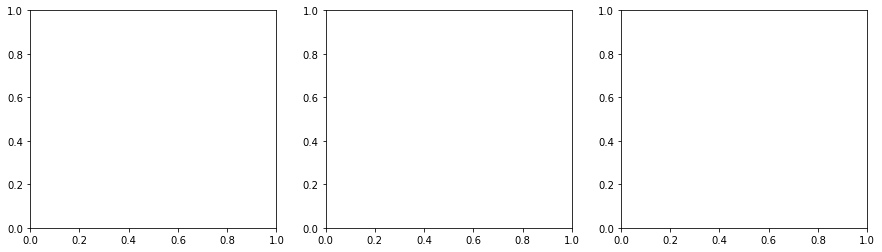

In [38]:
%%time
fig, ax = plt.subplots(1,3, figsize=(15,4))

im = ax[0].pcolormesh(XL, YL.sel(time=plot_year, method='nearest'),
                    (psi.sel(time=plot_year, method='nearest').sum(dim='xt_ocean')).T/rho_0, cmap='RdBu_r', vmin=-20e6, vmax=20e6)
ax[0].set_title('$\Psi$')
plt.colorbar(im, ax=ax[0])

im2 = ax[1].pcolormesh(XL, YL.sel(time=plot_year, method='nearest'),
                     (psi_bar.sel(time=plot_year, method='nearest').sum(dim='xt_ocean'))/rho_0, cmap='RdBu_r', vmin=-20e6, vmax=20e6)
ax[1].set_title('$\overline{\Psi}$')
plt.colorbar(im2, ax=ax[1])

im3 = ax[2].pcolormesh(XL, YL.sel(time=plot_year, method='nearest'),
                     (psi_star.sel(time=plot_year, method='nearest').sum(dim='xt_ocean')).T/rho_0, cmap='RdBu_r', vmin=-20e6, vmax=20e6)
ax[2].set_title('$\Psi^{*}$')
plt.colorbar(im3, ax=ax[2])


fig.suptitle('Decade ending {0}'.format(plot_date));




### Calculate Standing meander overturning using Dufour et al. (2012) method
Define time average, zonal average $v$
Define time average, zonal averagh $h$
Compute $\Psi_{zm}$ from these. Get $\Psi_{sm}$ by difference.

In [ ]:

psi_zm = xr.ones_like(psi_bar)*histogram(pot_rho_2_yu_bar.where(pot_rho_2_yu_bar>0).mean(dim='xt_ocean'), 
                          bins=[potrho_edges.values], 
                          dim = ['st_ocean'],
                          weights=ty_trans_bar.mean(dim='xt_ocean')).rename(
                {'pot_rho_2_yu_bar_bin':'potrho'}).rename('psi_zm')



# MITgcm code to use for guidance
# psi_zm = xr.ones_like(psi_bar)*histogram(sigma2_bar.mean(dim='XC'), 
#                                           bins=[sigma2_layer_bounds], 
#                                           dim = ['Z'],
#                                           weights=(vbar*ds_state['drF']*ds_state['dxG']
#                                                    *ds_state['hFacS']).mean(dim='XC')).rename(
#                                                 {'sigma2_bin':'sigma2'}).rename('psi_zm')






In [ ]:
# psi_bar.load()
psi_zm.load()

psi_zp = psi_bar - psi_zm

In [ ]:
psi_zm.sel(time=plot_year, method='nearest').mean(dim='xt_ocean').plot()

#### Plot Eulerian-mean, zonal-mean, and zonal-perturbation overturning circulations

In [ ]:
%%time

fig, ax = plt.subplots(1,3, figsize=(15,4))

cumsum_from_bottom(psi_bar.sel(time=plot_year, method='nearest').sum(
    dim='xt_ocean')/rho_0).plot(ax=ax[0], y='potrho', yincrease=False, robust=True)
ax[0].set_title('$\overline{\Psi}$')

cumsum_from_bottom(psi_zm.sel(time=plot_year, method='nearest').sum(
    dim='xt_ocean')/rho_0).plot(ax=ax[1], y='potrho', yincrease=False, robust=True)
ax[1].set_title('$\Psi_{zm}$')


cumsum_from_bottom(psi_zp.sel(time=plot_year, method='nearest').sum(
    dim='xt_ocean')/rho_0).plot(ax=ax[2], y='potrho', yincrease=False, robust=True)
ax[2].set_title('$\Psi_{zp}$ - zonal perturbation')


fig.suptitle('Decade ending {0}'.format(plot_date));



plt.savefig('/g/data/jk72/ed7737/SO-channel_embayment/ACESS-OM2/{0}/figures/psi_bar_decomposition_{1}_to_{2}_sigma_space.png'.format(
    expt, decade_lims[0], decade_lims[1]), dpi=200, bbox_inches='tight')


In [ ]:
%%time
fig, ax = plt.subplots(1,3, figsize=(15,4))

im = ax[0].contourf(XL, YL.sel(time=plot_year, method='nearest'),
                    cumsum_from_bottom(psi_bar.sel(time=plot_year, method='nearest').sum(dim='xt_ocean'))/rho_0, cmap='RdBu_r', vmin=-25e6, vmax=25e6)
ax[0].set_title('$\overline{\Psi}$')
plt.colorbar(im, ax=ax[0])

im2 = ax[1].contourf(XL, YL.sel(time=plot_year, method='nearest'),
                     cumsum_from_bottom(psi_zm.sel(time=plot_year, method='nearest').sum(dim='xt_ocean'))/rho_0, cmap='RdBu_r', vmin=-25e6, vmax=25e6)
ax[1].set_title('$\Psi_{zm}$')
plt.colorbar(im2, ax=ax[1])

im3 = ax[2].contourf(XL, YL.sel(time=plot_year, method='nearest'),
                     cumsum_from_bottom(psi_zp.sel(time=plot_year, method='nearest').sum(dim='xt_ocean'))/rho_0, cmap='RdBu_r', vmin=-25e6, vmax=25e6)
ax[2].set_title('$\Psi_{zp}$')
plt.colorbar(im3, ax=ax[2])

fig.suptitle('Decade ending {0}'.format(plot_date));


# blue rotates counter-clockwise

plt.savefig('/g/data/jk72/ed7737/SO-channel_embayment/ACESS-OM2/{0}/figures/psi_bar_decomposition_{1}_to_{2}_depth_space.png'.format(
    expt, decade_lims[0], decade_lims[1]), dpi=200, bbox_inches='tight')


In [ ]:
%%time

fig, ax = plt.subplots(1,3, figsize=(15,4))

im = ax[0].pcolormesh(XL, YL.sel(time=plot_year, method='nearest'),
                      psi_bar.sel(time=plot_year, method='nearest').mean(dim='xt_ocean'), cmap='RdBu_r')#, vmin=-5e3, vmax=5e3)
ax[0].set_title('$\overline{\Psi}$')
plt.colorbar(im, ax=ax[0])

im2 = ax[1].pcolormesh(XL, YL.sel(time=plot_year, method='nearest'),
                       psi_zm.sel(time=plot_year, method='nearest').mean(dim='xt_ocean'), cmap='RdBu_r')#, vmin=-5e3, vmax=5e3)
ax[1].set_title('$\Psi_{zm}$')
plt.colorbar(im2, ax=ax[1])

im3 = ax[2].pcolormesh(XL, YL.sel(time=plot_year, method='nearest'),
                       psi_zp.sel(time=plot_year, method='nearest').mean(dim='xt_ocean'), cmap='RdBu_r')#, vmin=-5e3, vmax=5e3)
ax[2].set_title('$\Psi_{zp}$')
plt.colorbar(im3, ax=ax[2])

fig.suptitle('Decade ending {0}'.format(plot_date));





## Heat transport

Use the framework from Naviero Garabato et al. (2017):

$$
T(C) = \int_{0}^{L}\sum_{i=1}^{N} v(x,y,i,t) h(x,y,i,t) C(x,y,i,t) ds,
$$

where $L$ is the length of the face through the flux is transported, $v$ is the velocity normal to the face, $h$ is the layer thickness, $C$ is the tracer concentration, $i$ is the layer, and there are $N$ layers in total.


We can break this up into advective and diffusive contributions. We can then further break up the advective contribution into zonal-mean and standing meander.

Test heat flux in standing meanders - is it eddy diffusion that does the work, standing meander fluxes, or zonal mean fluxes?

Define zonal mean as $<\cdot>$, zonal perturbation as $\tilde{\cdot}$, time-mean as $\overline{\cdot}$, and time perturbation as $\cdot'$.

Now we can time-average and expand $T(C)$ into different terms.

$$
\overline{T}(C) = \int_{0}^{L}\sum_{i=1}^{N} \left(\overline{v} \overline{h} + \overline{v' h'}\right) \overline{C} ds + \int_{0}^{L}\sum_{i=1}^{N} \overline{(vh)' C'} ds,
$$

where the first term is the flux due to advection of the time-mean tracer by the overturning circulation and the second term is the flux due to eddy diffusion. The advective flux includes contributions from the time-mean overturning, $\overline{v} \overline{h}$, and the eddy-induced overturning, $\overline{v' h'}$. The time-mean overturning can be further broken down into zonal-mean and zonal-perturbation components.

$$
\overline{T}(C) = \int_{0}^{L}\sum_{i=1}^{N} \left(<\overline{v}> <\overline{h}> + \overline{\tilde{v}} \overline{\tilde{h}} \right) (<\overline{C}> + \overline{\tilde{C}}) + \overline{v' h'} \overline{C} ds + \int_{0}^{L}\sum_{i=1}^{N} \overline{(vh)' C'} ds,
$$

Expanding terms and removing single perturbation terms, which integrate to zero, gives

$$
\overline{T}(C) = \int_{0}^{L}\sum_{i=1}^{N} \left(<\overline{v}> <\overline{h}> <\overline{C}>  + \overline{\tilde{v}} \overline{\tilde{h}} \right) (<\overline{C}> + \overline{\tilde{C}}) + \overline{v' h'} \overline{C} ds + \int_{0}^{L}\sum_{i=1}^{N} \overline{(vh)' C'} ds,
$$



$$
\overline{T}(C) = \int_{0}^{L}\sum_{i=1}^{N} \left(<\overline{v}> <\overline{h}> <\overline{C}>  + \overline{\tilde{v}} \overline{\tilde{h}} \right) <\overline{C}> + \widetilde{(\overline{v}\overline{h})}\tilde{\overline{C}} + \overline{v' h'} \overline{C} ds + \int_{0}^{L}\sum_{i=1}^{N} \overline{(vh)' C'} ds,
$$

$$
T(C) = <\overline{\Psi}><\overline{C}> + \Psi_{sm}\overline{C} + \Psi^{*}\overline{C} + \overline{(vh)'C'}
$$

In [ ]:
psi.interp(time=ty_trans_rho.time, method='nearest').sel(
    xt_ocean=-30, method='nearest').sel(
    yu_ocean=-50, method='nearest').sel(
    potrho=1037, method='nearest').plot()

In [ ]:
psi.resample(time="1M").bfill().sel(
    xt_ocean=-30, method='nearest').sel(
    yu_ocean=-50, method='nearest').sel(
    potrho=1037, method='nearest').values

In [ ]:
psi.sel(
    xt_ocean=-30, method='nearest').sel(
    yu_ocean=-50, method='nearest').sel(
    potrho=1037, method='nearest').plot()

ty_trans_rho.sel(
    xt_ocean=-30, method='nearest').sel(
    yu_ocean=-50, method='nearest').sel(
    potrho=1037, method='nearest').plot()
# plt.hlines(0, '1960-01-01', '2020-12-31')

In [ ]:


# vh_prime = xr.zeros_like(ty_trans_rho.sel(time=slice(time_lims[0], time_lims[1]))).rename('vh_prime')

vh_prime = (ty_trans_rho.sel(time=slice(time_lims[0], time_lims[1])) - psi.sel(time=time_lims[1]))



# loop through psi times, and calculate vh_prime for each segment - not as straightforward due to decadal averaging.


In [ ]:
vh_prime

In [ ]:
vh_prime.sel(
    xt_ocean=-30, method='nearest').sel(
    yu_ocean=-50, method='nearest').sel(
    potrho=1037, method='nearest').plot()

ty_trans_rho.sel(time=slice(time_lims[0], time_lims[1])).sel(
    xt_ocean=-30, method='nearest').sel(
    yu_ocean=-50, method='nearest').sel(
    potrho=1037, method='nearest').plot()

In [ ]:

# Need to use the linear transformation from xgcm for temperature, since it is not an
# extensive property. Don't use xhistogram: it gives weird values.

temperature_yu = grid.interp(temperature, 'Y', boundary='extend')

layerwise_temperature = grid.transform(temperature_yu.sel(time=slice(time_lims[0], time_lims[1])).chunk(dict(st_ocean=-1)),
                                          'Z',
                                          potrho.values,
                                          method='linear',
                                          target_data=pot_rho_2_yu.sel(time=slice(time_lims[0], time_lims[1])).chunk(dict(st_ocean=-1)),
                                          mask_edges=False,).rename({'pot_rho_2':'potrho'})

In [ ]:
layerwise_temperature

In [ ]:
# reference temperature of -2°C
ref_temp = 273.15 - 2

In [ ]:
%%time

try:
    vhc_reconstructed_bar = xr.open_dataarray(
                                '/g/data/jk72/ed7737/SO-channel_embayment/ACESS-OM2/'+
                                '{0}/data/vhc_reconstructed_bar_{1}_{2}.nc'.format(expt, decade_lims[0], decade_lims[1]), chunks='auto')
except:
    vhc_reconstructed = ty_trans_rho*(layerwise_temperature - ref_temp)
    vhc_reconstructed_bar = vhc_reconstructed.mean(dim='time')

    # vhc_reconstructed_bar = vhc_reconstructed_bar.load()
    vhc_reconstructed_bar.sel(time=decade_lims[1],
                              method='nearest').to_netcdf('/g/data/jk72/ed7737/SO-channel_embayment/ACESS-OM2/'+
                                                        '{0}/data/vhc_reconstructed_bar_{1}_{2}.nc'.format(expt, decade_lims[0],
                                                                                                           decade_lims[1]))






In [ ]:
%%time

try:
    layerwise_Tbar = xr.open_dataarray('/g/data/jk72/ed7737/SO-channel_embayment/ACESS-OM2/'+
                                       '{0}/data/layerwise_Tbar_{1}_{2}.nc'.format(expt, decade_lims[0], decade_lims[1]),
                                       chunks='auto')
except:
    layerwise_Tbar = grid.transform(temperature_yu.sel(time=slice(time_lims[0], time_lims[1])).mean(dim='time').chunk(dict(st_ocean=-1)),
                                              'Z',
                                              potrho,
                                              method='linear',
                                              target_data=pot_rho_2_yu.sel(time=slice(time_lims[0], time_lims[1])).mean(dim='time').chunk(dict(st_ocean=-1)),
                                           mask_edges=False).rename('layerwise_Tbar')
    # layerwise_Tbar = layerwise_Tbar.load()
    layerwise_Tbar.to_netcdf('/g/data/jk72/ed7737/SO-channel_embayment/ACESS-OM2/'+
                             '{0}/data/layerwise_Tbar_{1}_{2}.nc'.format(expt, decade_lims[0], decade_lims[1]))





In [ ]:
(layerwise_Tbar-273.15).mean(dim='xt_ocean').plot(y='potrho', yincrease=False)

In [ ]:

Tprime = layerwise_temperature - layerwise_Tbar



In [ ]:
%%time
    
try:
    vh_prime_Tprime_bar = xr.open_dataarray('/g/data/jk72/ed7737/SO-channel_embayment/ACESS-OM2/'+
                                            '{0}/vh_prime_Tprime_bar_{1}_{2}.nc'.format(expt, decade_lims[0], decade_lims[1]), chunks='auto')
except:
    # eddy diffusive transport
    vh_prime_Tprime_bar = (vh_prime*Tprime).mean(dim='time')
    # vh_prime_Tprime_bar = vh_prime_Tprime_bar.load()
    vh_prime_Tprime_bar.to_netcdf('/g/data/jk72/ed7737/SO-channel_embayment/ACESS-OM2/'+
                                  '{0}/vh_prime_Tprime_bar_{1}_{2}.nc'.format(expt, decade_lims[0], decade_lims[1]))


In [ ]:
# Advective heat transport
psi_Tbar = psi.sel(time=time_lims[1])*(layerwise_Tbar - ref_temp)

# is made up of Eulerian-mean and eddy

# Eulerian-mean overturning heat transport
psibar_Tbar = psi_bar.sel(time=time_lims[1])*(layerwise_Tbar - ref_temp)
    # is made up of
    # zonal-mean
psizm_Tbar = psi_zm.sel(time=time_lims[1])*(layerwise_Tbar - ref_temp)
    # standing meander
psizp_Tbar = psi_zp.sel(time=time_lims[1])*(layerwise_Tbar - ref_temp)


# eddy overturning heat ransport
psistar_Tbar = psi_star.sel(time=time_lims[1])*(layerwise_Tbar - ref_temp)


### Basin wide averages - does this method work?
Yes! (In MITgcm - need to verify ACCESS models. Looks like probably not at the moment with monthly outputs.)

In [ ]:
#vhc_bar.sum(dim=['YG', 'XC']).plot(y='sigma2', yincrease=False, label='Total transport of heat')

vhc_reconstructed_bar.sum(dim=['yu_ocean', 'xt_ocean']).plot(y='potrho', yincrease=False, label='Reconstructed total transport of heat')


plt.legend()

In [ ]:
# 15 june - new attempt
(psi_Tbar).sum(dim=['yu_ocean', 'xt_ocean']).plot(y='potrho', yincrease=False, label='MOC advection of heat')
(vh_prime_Tprime_bar).sum(dim=['yu_ocean', 'xt_ocean']).plot(y='potrho', yincrease=False, label='Eddy diffusion of heat')
vhc_reconstructed_bar.sum(dim=['yu_ocean', 'xt_ocean']).plot(y='potrho', yincrease=False, label='Total transport of heat')

plt.legend()

### Zonal-mean plots - where is this transport happening?

Text(0.5, 1.0, "$(vh)' T'$")

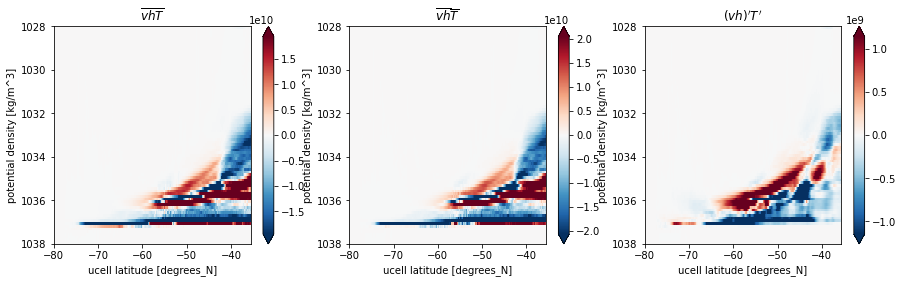

In [81]:
%%time
fig, ax = plt.subplots(1,3, figsize=(15,4))

vhc_reconstructed_bar.sum(dim='xt_ocean').plot(ax=ax[0], y='potrho', yincrease=False, robust=True)
ax[0].set_title('$\overline{vhT}$')

psi_Tbar.sum(dim='xt_ocean').plot(ax=ax[1], y='potrho', yincrease=False, robust=True)
ax[1].set_title('$\overline{vh} \overline{T}$')

# (vhc_reconstructed_bar - psi_Tbar).sum(dim='xt_ocean').plot(ax=ax[2], y='potrho', yincrease=False, robust=True)
# ax[2].set_title("$(vh)' T'$")

vh_prime_Tprime_bar.sum(dim='xt_ocean').plot(ax=ax[2], y='potrho', yincrease=False, robust=True)
ax[2].set_title("$(vh)' T'$")





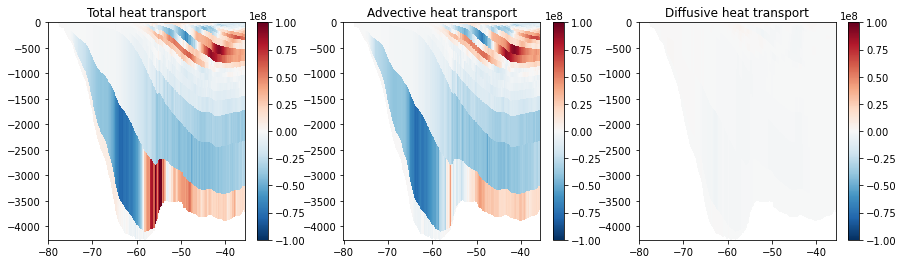

In [86]:
fig, ax = plt.subplots(1,3, figsize=(15,4))

im = ax[0].pcolormesh(XL, YL.sel(time=time_lims[1]), vhc_reconstructed_bar.sum(dim='xt_ocean').T/rho_0, cmap='RdBu_r', vmin=-10e7, vmax=10e7)
ax[0].set_title('Total heat transport')
plt.colorbar(im, ax=ax[0])

im2 = ax[1].pcolormesh(XL, YL.sel(time=time_lims[1]), psi_Tbar.sum(dim='xt_ocean').T/rho_0, cmap='RdBu_r', vmin=-10e7, vmax=10e7)
ax[1].set_title('Advective heat transport')
plt.colorbar(im2, ax=ax[1])

# # diagnose eddies as the difference
# im3 = ax[2].pcolormesh(XL, YL.sel(time=time_lims[1]), (vhc_reconstructed_bar - psi_Tbar).sum(dim='xt_ocean').T/rho_0, cmap='RdBu_r', vmin=-10e7, vmax=10e7)
# ax[2].set_title('Diffusive heat transport')
# plt.colorbar(im3, ax=ax[2])


im3 = ax[2].pcolormesh(XL, YL.sel(time=time_lims[1]), vh_prime_Tprime_bar.sum(dim='xt_ocean').T/rho_0, cmap='RdBu_r', vmin=-10e7, vmax=10e7)
ax[2].set_title('Diffusive heat transport')
plt.colorbar(im3, ax=ax[2])



plt.savefig('ACCESS-025-total_heat_transport_decomposition_{0}_to_{1}_depth_space.png'.format(decade_lims[0], decade_lims[1]), dpi=200, bbox_inches='tight')



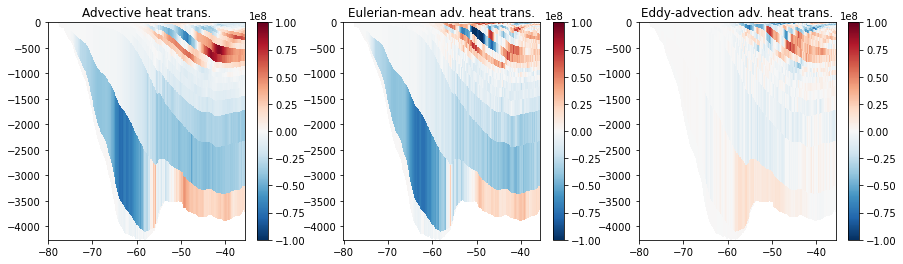

In [88]:
fig, ax = plt.subplots(1,3, figsize=(15,4))

im = ax[0].pcolormesh(XL, YL.sel(time=time_lims[1]), psi_Tbar.sum(dim='xt_ocean').T/rho_0, cmap='RdBu_r', vmin=-10e7, vmax=10e7)
ax[0].set_title('Advective heat trans.')
plt.colorbar(im2, ax=ax[0])

im = ax[1].pcolormesh(XL, YL.sel(time=time_lims[1]), psibar_Tbar.sum(dim='xt_ocean')/rho_0, cmap='RdBu_r', vmin=-10e7, vmax=10e7)
ax[1].set_title('Eulerian-mean adv. heat trans.')
plt.colorbar(im, ax=ax[1])


im3 = ax[2].pcolormesh(XL, YL.sel(time=time_lims[1]), (psistar_Tbar).sum(dim='xt_ocean').T/rho_0, cmap='RdBu_r', vmin=-10e7, vmax=10e7)
ax[2].set_title('Eddy-advection adv. heat trans.')
plt.colorbar(im3, ax=ax[2])



plt.savefig('ACCESS-025-advective_heat_transport_decomposition_{0}_to_{1}_depth_space.png'.format(decade_lims[0], decade_lims[1]), dpi=200, bbox_inches='tight')




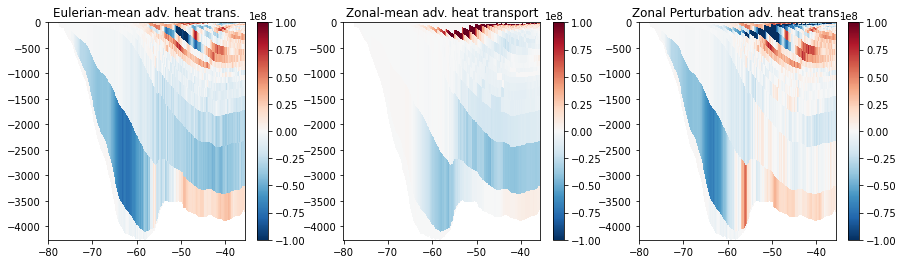

In [89]:
fig, ax = plt.subplots(1,3, figsize=(15,4))

im = ax[0].pcolormesh(XL, YL.sel(time=time_lims[1]), psibar_Tbar.sum(dim='xt_ocean')/rho_0, cmap='RdBu_r', vmin=-10e7, vmax=10e7)
ax[0].set_title('Eulerian-mean adv. heat trans.')
plt.colorbar(im2, ax=ax[0])

im = ax[1].pcolormesh(XL, YL.sel(time=time_lims[1]), psizm_Tbar.sum(dim='xt_ocean')/rho_0, cmap='RdBu_r', vmin=-10e7, vmax=10e7)
ax[1].set_title('Zonal-mean adv. heat transport')
plt.colorbar(im, ax=ax[1])


im3 = ax[2].pcolormesh(XL, YL.sel(time=time_lims[1]), psizp_Tbar.sum(dim='xt_ocean')/rho_0, cmap='RdBu_r', vmin=-10e7, vmax=10e7)
ax[2].set_title('Zonal Perturbation adv. heat trans.')
plt.colorbar(im3, ax=ax[2])


plt.savefig('ACCESS-025-Eulerian-mean_advective_heat_transport_decomposition_{0}_to_{1}_depth_space.png'.format(decade_lims[0], decade_lims[1]), dpi=200, bbox_inches='tight')



### x-y plots on a density surface


In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15,4))

vhc_bar.sel(sigma2=35.8, method='nearest').plot(ax=ax[0], vmin=-5e5, vmax=5e5, cmap='RdBu_r')
ax[0].set_title('Total heat trans.')
# plt.colorbar(im2, ax=ax[0])


psi_Tbar.sel(sigma2=35.8, method='nearest').plot(ax=ax[1], vmin=-5e5, vmax=5e5, cmap='RdBu_r')
ax[1].set_title('Advective heat transport')


vh_prime_Tprime_bar.sel(sigma2=35.8, method='nearest').plot(ax=ax[2], vmin=-5e4, vmax=5e4, cmap='RdBu_r')
ax[2].set_title('Diffusive heat transport')





In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15,4))

vhc_bar.sum(dim='sigma2').plot(ax=ax[0], vmin=-2e7, vmax=2e7, cmap='RdBu_r')
ax[0].set_title('Total heat trans.')
# plt.colorbar(im2, ax=ax[0])
ax[0].set_aspect('equal')



psi_Tbar.sum(dim='sigma2').plot(ax=ax[1], vmin=-2e7, vmax=2e7, cmap='RdBu_r')
ax[1].set_title('Advective heat transport')
ax[1].set_aspect('equal')


# this is two order of magnitude smaller - shows up with vmin/vmax=2e5
vh_prime_Tprime_bar.sum(dim='sigma2').plot(ax=ax[2], vmin=-2e7, vmax=2e7, cmap='RdBu_r')
ax[2].set_title('Diffusive heat transport')
ax[2].set_aspect('equal')




## Heat and volume transport onto the shelf

Begin with tansport over lines of latitude. Given the geomtry, this may be enough to get a good estimate of meridional heat flux over an isobath.

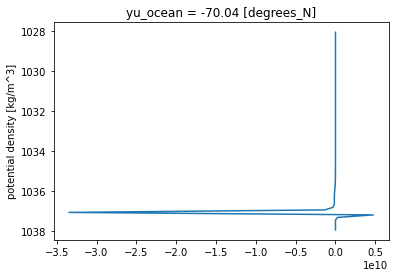

In [91]:
vhc_reconstructed_bar.sel(yu_ocean=-70, method='nearest').sum(dim='xt_ocean').plot(y='potrho', yincrease=False)
# plt.ylim(37.5, 34)

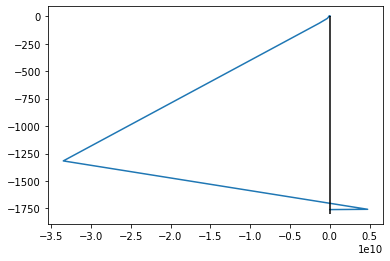

In [93]:
plt.plot(vhc_reconstructed_bar.sel(yu_ocean=-70, method='nearest').sum(dim='xt_ocean'),
    -hbar.sel(yu_ocean=-70, method='nearest').sel(time=time_lims[1]).mean(dim='xt_ocean').cumsum(dim='potrho'))
plt.vlines(0,-1800,0, colors='k')

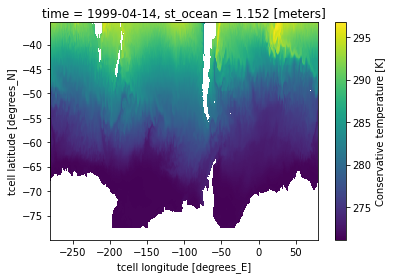

In [111]:
temperature.sel(time='1999-04-16', method='nearest').sel(st_ocean=0, method='nearest').plot()

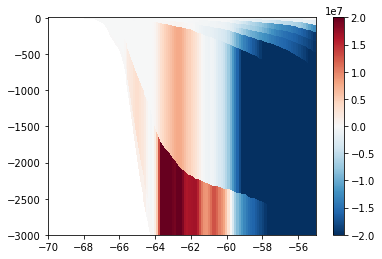

In [115]:
plt.pcolormesh(XL, -hbar.sel(time=time_lims[1]).sel(xt_ocean=slice(-280,-220)).mean(dim='xt_ocean').cumsum(dim='potrho'),
               vhc_reconstructed_bar.sel(xt_ocean=slice(-280,-220)).sum(dim='xt_ocean').T/rho_0, vmin=-2e7, vmax=2e7, cmap='RdBu_r')
plt.xlim(-70, -55)
plt.ylim(-3000, 10)
plt.colorbar()


### Next steps: break the heat and volume transport down into the different terms

(1037.5, 1035.5)

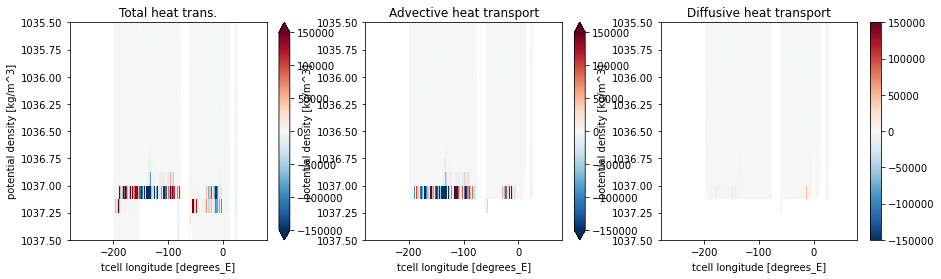

In [121]:
fig, ax = plt.subplots(1,3, figsize=(15,4))

(vhc_reconstructed_bar/rho_0).sel(yu_ocean=-70, method='nearest').plot(ax=ax[0], y='potrho', yincrease=False, vmin=-15e4, vmax=15e4, cmap='RdBu_r')
ax[0].set_title('Total heat trans.')
# plt.colorbar(im2, ax=ax[0])


(psi_Tbar/rho_0).sel(yu_ocean=-70, method='nearest').plot(ax=ax[1], y='potrho', yincrease=False, vmin=-15e4, vmax=15e4, cmap='RdBu_r')
ax[1].set_title('Advective heat transport')


(vh_prime_Tprime_bar/rho_0).sel(yu_ocean=-70, method='nearest').plot(ax=ax[2], y='potrho', yincrease=False, vmin=-15e4, vmax=15e4, cmap='RdBu_r')
ax[2].set_title('Diffusive heat transport')


ax[0].set_ylim(1037.5, 1035.5)
ax[1].set_ylim(1037.5, 1035.5)
ax[2].set_ylim(1037.5, 1035.5)




In [ ]:
yloc = 2e6

fig, ax = plt.subplots(1,3, figsize=(15,4))

vhc_bar.sel(YG=yloc, method='nearest').plot(ax=ax[0], y='sigma2', yincrease=False, robust=True)# vmin=-15e2, vmax=15e2, cmap='RdBu_r')
ax[0].set_title('Total heat trans.')
# plt.colorbar(im2, ax=ax[0])


psi_Tbar.sel(YG=yloc, method='nearest').plot(ax=ax[1], y='sigma2', yincrease=False, robust=True)# vmin=-15e2, vmax=15e2, cmap='RdBu_r')
ax[1].set_title('Advective heat transport')


vh_prime_Tprime_bar.sel(YG=yloc, method='nearest').plot(ax=ax[2], y='sigma2', yincrease=False, robust=True)# vmin=-15e2, vmax=15e2, cmap='RdBu_r')
ax[2].set_title('Diffusive heat transport')







In [ ]:
(vh_prime_Tprime_bar/vhc_bar).sel(YG=0.6e6, method='nearest').plot(y='sigma2', yincrease=False, vmin=-0.75, vmax=0.75, cmap='RdBu_r')


### Heat transport over lines of latitude

CPU times: user 9.38 s, sys: 986 ms, total: 10.4 s
Wall time: 33 s


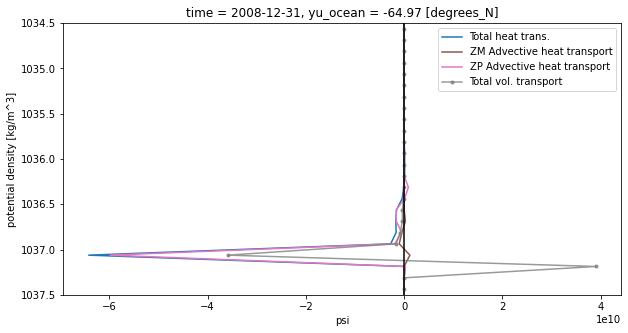

In [133]:
%%time

yloc = -65

plt.figure(figsize=(10,5))

(psi_Tbar + vh_prime_Tprime_bar).sel(yu_ocean=yloc, method='nearest').sum(dim='xt_ocean').plot(y='potrho', yincrease=False, label='Total heat trans.', color='C0')

# vh_prime_Tprime_bar.sel(yu_ocean=yloc, method='nearest').sum(dim='xt_ocean').plot(y='potrho', yincrease=False, label='Diffusive heat transport', color='C1')

# psi_Tbar.sel(yu_ocean=yloc, method='nearest').sum(dim='xt_ocean').plot(y='potrho', yincrease=False, label='Advective heat transport', color='C2')


# psibar_Tbar.sel(yu_ocean=yloc, method='nearest').sum(dim='xt_ocean').plot(y='potrho', yincrease=False, label='Eulerian-mean Advective heat transport', color='C3')

# psistar_Tbar.sel(yu_ocean=yloc, method='nearest').sum(dim='xt_ocean').plot(y='potrho', yincrease=False, label='Eddy Advective heat transport', color='C4')



psizm_Tbar.sel(yu_ocean=yloc, method='nearest').sum(dim='xt_ocean').plot(y='potrho', yincrease=False, label='ZM Advective heat transport', color='C5')

psizp_Tbar.sel(yu_ocean=yloc, method='nearest').sum(dim='xt_ocean').plot(y='potrho', yincrease=False, label='ZP Advective heat transport', color='C6')




psi.sel(time=time_lims[1]).sel(yu_ocean=yloc, method='nearest').sum(dim='xt_ocean').plot(y='potrho', yincrease=False,
                                                                                         label='Total vol. transport', color='grey',
                                                                                         alpha=0.8,# marker='.'
                                                                                        )



plt.vlines(0, 1028, 1038, 'k')
plt.legend()
plt.ylim(1037.5, 1034.5)

# plt.text(-2.4e6, 1037.1, 'NADW')
# plt.text(-5.8e6, 1036, 'Surface waters')
# plt.text(2.2e6, 1036.6, 'AAIW')
# plt.text(1e6, 1037.2, 'AABW')


plt.savefig('ACCESS-O1-y={0}_heat_volume_fluxes_flow_decomposition_4.png'.format(yloc), dpi=200, bbox_inches='tight')

(1037.5, 1034.5)

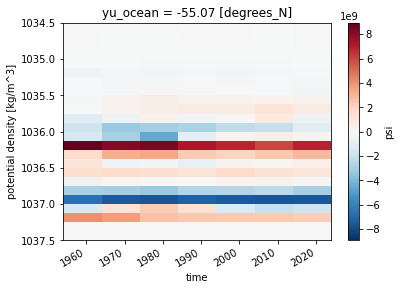

In [130]:

psi.sel(yu_ocean=yloc, method='nearest').sum(dim='xt_ocean').plot(y='potrho', yincrease=False)

plt.ylim(1037.5, 1034.5)
